In [1]:
from math import sin,cos,pi,log,exp
import matplotlib.pyplot as plt
import numpy as np
import cfeplib

In [2]:
f=open('oxtrajtraj-3-0.rmsd')
lrmsd=[]
for l in f:
    l=l.split()
    lrmsd.append(float(l[1]))
f.close()

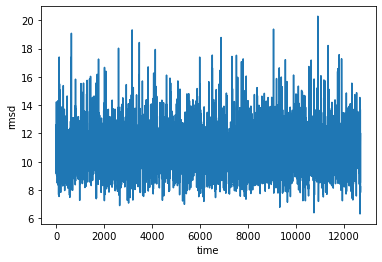

In [3]:
plt.plot(lrmsd[0:-1:100])
plt.xlabel('time')
_=plt.ylabel('rmsd')

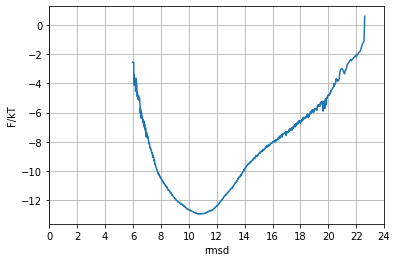

In [4]:
lx,lzh=cfeplib.comp_Zca(lrmsd,a=-1,dx=0.01,dt=1,strict=False)
lf=[-log(zh*2) for zh in lzh]

plt.plot(lx,lf)
plt.xticks(np.arange(0, 25, step=2))
plt.grid()
plt.xlabel('rmsd')
_=plt.ylabel('F/kT')


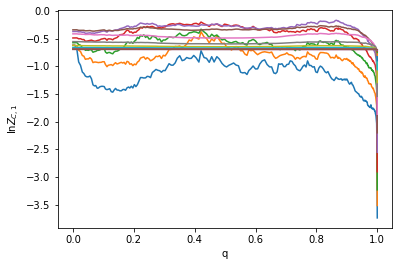

In [5]:
lq=cfeplib.to_committor(lrmsd,0.01,4,10)

ldt=[2**i for i in range(16)]
dx=0.001
for dt in ldt:
    ekn=cfeplib.comp_ekn_tp(lq,x0=0,x1=1,dx=dx,dt=dt)
    lx,lzc1=cfeplib.comp_Zca_ekn(ekn,a=1)
    plt.plot(lx,-np.log(lzc1))
plt.xlabel('q')
_=plt.ylabel('$\ln Z_{C,1}$')

In [6]:
def Nab_traj(lrmsd,a,b):
    il=None
    n=0
    for x in lrmsd:
        ic=None
        if x<a: ic=1
        if x>b: ic=2
        if ic!=None and il!=None and ic!=il: n+=1
        if ic!=None: il=ic
    return n/2.
        
def Nab_model(lx,lzc1,a,b):
    lx1=[lx[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    ly1=[1/lzc1[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    
    from scipy.integrate import simps
    I=simps(ly1,lx1)
    return 1./I

a=4
b=10
lx1,ly1=cfeplib.comp_Zca(lrmsd,a=1,dx=0.0001)
print (Nab_traj(lrmsd,a,b),Nab_model(lx1,ly1,a,b))

2.0 3.9341552834337876


In [7]:
for dt in range(1,11):
    traj1=[lrmsd[i] for i in range(1,len(lrmsd),dt)]
    lx1,ly1=cfeplib.comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))

1 2.0 3.9341552834337876
2 1.0 2.7460934314366714
3 1.0 2.849286501498778
4 1.0 2.2523205072325845
5 1.0 2.288499900915351
6 1.0 2.011751980449994
7 1.0 0.7663196152775582
8 1.0 1.2877676531405142
9 1.0 3.85850088636695
10 1.0 1.6136886862420732


In [8]:
for dt in range(10,40):
    traj1=[lrmsd[i] for i in range(1,len(lrmsd),dt)]
    lx1,ly1=cfeplib.comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))

10 1.0 1.6136886862420732
11 1.0 1.630600248041325
12 1.0 1.9297991199733722
13 2.0 1.9478136832481354
14 1.0 2.2839352267890103
15 1.0 2.1278470892817203
16 1.0 1.2725888559910745
17 1.0 1.7287087034915825
18 1.0 -0.04434608554360633
19 1.0 1.498540243885182
20 1.0 1.7917354178468439
21 1.0 1.9396911889536776
22 1.0 1.08215013183717
23 1.0 1.7363256369433697
24 1.0 1.849432887424035
25 1.0 2.587319024533171
26 1.0 1.4465422094658562
27 1.0 1.6542038879359893
28 1.0 2.0759274977106763
29 1.0 2.0649954856320845
30 1.0 1.5681520954872856
31 1.0 1.8207693414100323
32 1.0 2.214397519847926
33 1.0 1.943515917497626
34 1.0 1.7707611719813527
35 1.0 3.71808592891389
36 1.0 -0.06261963121256883
37 1.0 0.012984685118099033
38 1.0 1.856181713856468
39 1.0 1.43871892585792


In [9]:
def fab_model(lrmsd,a,b,dx=0.001):
    lx,lzc1=cfeplib.comp_Zca(lrmsd,1,dx=dx)
    lx,lzh=cfeplib.comp_Zca(lrmsd,-1,dx=dx)
    from scipy.integrate import cumtrapz,simps
    ly=[1/y for y in lzc1]
    lq=cumtrapz(ly,lx,initial=0)
    lqa=[(abs(x-a),i) for i,x in enumerate(lx)]
    lqa.sort()
    ia=lqa[0][-1]
    qa=lq[ia]
    lqb=[(abs(x-b),i) for i,x in enumerate(lx)]
    lqb.sort()
    ib=lqb[0][-1]
    qb=lq[ib]
    def qp(q,qa,qb):
        if q<qa: return 0
        if q>qb: return 1
        return (q-qa)/(qb-qa)
    lqp=[qp(q,qa,qb) for q in lq]
    lind=[1 if a<x and x<b else 0 for x in lx]
    nab=1/simps([ind/zc1 for ind,zc1 in zip(lind,lzc1)],lx)
    n=len(lrmsd)
    ztot=simps(lzh,lx)
    mfptab=simps([zh*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mfptba=simps([zh*q for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mtpt=simps([zh*q*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    return nab,mfptab,mfptba,mtpt

def fab_traj(lrmsd,a,b):
    il=None
    nab=0
    mfptab=0
    mfptba=0
    mtpt=0
    tp=0
    fp=0
    for i,x in enumerate(lrmsd):
        if x<a: 
            ic=1
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptba=mfptba+i-fp
                fp=i
            il=ic
            tp=i
        if x>b: 
            ic=2
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptab=mfptab+i-fp
                fp=i
            il=ic
            tp=i
    return nab/2.,2.*mfptab/nab,2.*mfptba/nab,float(mtpt)/nab
     
print('model: NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_model(lrmsd,a,b))    
print('traj:  NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_traj(lrmsd,a,b))

model: NAB=3.86469, mfpt_AB=-272.447, mftp_BA=326087, mtpt=50.6988
traj:  NAB=2, mfpt_AB=178, mftp_BA=209230, mtpt=113
